In [4]:
%matplotlib inline

import zipline
from zipline.api import order_target_percent, symbol,  \
    set_commission, set_slippage, schedule_function, \
    date_rules, time_rules
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from scipy import stats  
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

"""
Model Settings
"""
intial_portfolio = 100000
momentum_window1 = 125
momentum_window2 = 125
minimum_momentum = 40
portfolio_size = 30
vola_window = 20

# Trend filter settings
enable_trend_filter = False
trend_filter_symbol = 'SPY'
trend_filter_window = 200

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05

"""
Helper functions.
"""

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts) 
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    #Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

def volatility(ts):
    return ts.pct_change().rolling(vola_window).std().iloc[-1]

"""
Initialization and trading logic
"""
def initialize(context):
   
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
        set_slippage(slippage_model)
    else:
        slippage_model=FixedSlippage(spread=0.0)        
    
    # Used only for progress output.
    context.last_month = intial_portfolio
    
    # Store index membership
    context.index_members = pd.read_csv('Data/index_members/sp500_20200801_v2.csv', index_col=0, parse_dates=[0])
    
    #Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )
    
def output_progress(context):
    """
    Output some performance numbers during backtest run
    """
    
    # Get today's date
    today = zipline.api.get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value
       
    
def rebalance(context, data):
    # Write some progress output during the backtest
    output_progress(context)
    
    # Check which stocks are part of the index today. Data prefetched earlier.
    today = zipline.api.get_datetime()#.date()
    
    
  
    # Ok, let's find which stocks can be traded today.
    # First, get the index makeup for all days prior to today.
    all_prior = context.index_members.loc[context.index_members.index < today]
    
    # Now let's snag the first column of the last, i.e. latest, entry.
    latest_day = all_prior.iloc[-1,0]
    
    # Split the text string with tickers into a list
    list_of_tickers = latest_day.split(',')
    
    # Finally, get the Zipline symbols for the tickers
    todays_universe = [symbol(ticker) for ticker in list_of_tickers]
    
    # There's your daily universe. But we could of course have done this in one go.
    """       
    
    # This line below does the same thing,
    # using the same logic to fetch today's stocks.
    
    todays_universe = [
        symbol(ticker) for ticker in 
        context.index_members.loc[context.index_members.index < today].iloc[-1,0].split(',')
    ]
    """    
    

    # Check how long history window we need.
    hist_window = max(momentum_window1,
                      momentum_window2) 
    
    # Get historical data
    hist = data.history(todays_universe, "close", hist_window, "1d")
    
    # Slice the history to match the two chosen time frames.
    momentum_hist1 = hist[(-1 * momentum_window1):]
    momentum_hist2 = hist[(-1 * momentum_window2):]
    
    # Calculate momentum values for the two time frames.
    momentum_list1 = momentum_hist1.apply(momentum_score)  
    momentum_list2 = momentum_hist2.apply(momentum_score) 
    
    # Now let's put the two momentum values together, and calculate mean.
    momentum_concat = pd.concat((momentum_list1, momentum_list2))
    mom_by_row = momentum_concat.groupby(momentum_concat.index)
    mom_means = mom_by_row.mean()
    
    # Sort by momentum value.
    ranking_table = mom_means.sort_values(ascending=False)

    """
    Sell Logic
    
    First we check if any existing position should be sold.
    * Sell if stock is no longer part of index.
    * Sell if stock has too low momentum value.
    """
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in todays_universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)          
        elif ranking_table[security] < minimum_momentum:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)         
    
    """
    Trend Filter Section
    """
    if enable_trend_filter:
        ind_hist = data.history(
            symbol(trend_filter_symbol), 
            'close', 
            trend_filter_window, 
            '1d'
        )
        
        trend_filter = ind_hist.iloc[-1] > ind_hist.mean()    
        if trend_filter == False:
            return    
    
    """
    Stock Selection Logic
    
    Check how many stocks we are keeping from last month.
    Fill from top of ranking list, until we reach the
    desired total number of portfolio holdings.
    """
    replacement_stocks = portfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[
        ~ranking_table.index.isin(kept_positions)][:replacement_stocks]
    
    new_portfolio = pd.concat(
        (buy_list, 
         ranking_table.loc[ranking_table.index.isin(kept_positions)])
    )
    

    """
    Calculate inverse volatility for stocks, 
    and make target position weights.
    """
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] > minimum_momentum:
                order_target_percent(security, weight)

def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return   
        
# Set start and end date
start_date = pd.Timestamp('2016-1-1', tz='utc')
end_date = pd.Timestamp('2020-7-25', tz='utc')

perf = zipline.run_algorithm(
    start=start_date, end=end_date, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=intial_portfolio,  
    data_frequency = 'daily', 
    bundle='daily-csvdir-bundle') 



2016-01-04 - Last Month Result: 0.00%
2016-02-01 - Last Month Result: -1.22%
2016-03-01 - Last Month Result: 0.11%
2016-04-01 - Last Month Result: 2.11%
2016-05-02 - Last Month Result: -0.85%
2016-06-01 - Last Month Result: 0.33%
2016-07-01 - Last Month Result: 4.44%
2016-08-01 - Last Month Result: 0.81%
2016-09-01 - Last Month Result: 0.09%
2016-10-03 - Last Month Result: 1.44%
2016-11-01 - Last Month Result: -3.81%
2016-12-01 - Last Month Result: 6.02%
2017-01-03 - Last Month Result: 4.03%
2017-02-01 - Last Month Result: 0.49%
2017-03-01 - Last Month Result: 6.37%
2017-04-03 - Last Month Result: -4.94%
2017-05-01 - Last Month Result: 2.35%
2017-06-01 - Last Month Result: 4.10%
2017-07-03 - Last Month Result: -3.04%
2017-08-01 - Last Month Result: 4.52%
2017-09-01 - Last Month Result: 1.61%
2017-10-02 - Last Month Result: 2.34%
2017-11-01 - Last Month Result: 4.46%
2017-12-01 - Last Month Result: 3.20%
2018-01-02 - Last Month Result: 1.75%
2018-02-01 - Last Month Result: 7.35%
2018-03

Start date,2016-01-04
End date,2020-07-24
Total months,54
,Backtest
Annual return,2.3%
Cumulative returns,10.8%
Annual volatility,20.1%
Sharpe ratio,0.21
Calmar ratio,0.05
Stability,0.26
Max drawdown,-43.3%


/Users/leehongkai/anaconda/envs/trading/lib/python3.5/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,43.28,2018-08-29,2020-03-23,NaT,NaN
1,10.31,2018-01-26,2018-02-08,2018-06-11,97
2,8.69,2017-03-01,2017-04-13,2017-05-25,62
3,7.00,2016-08-23,2016-11-04,2016-11-15,61
4,5.02,2016-12-08,2017-01-17,2017-02-13,48


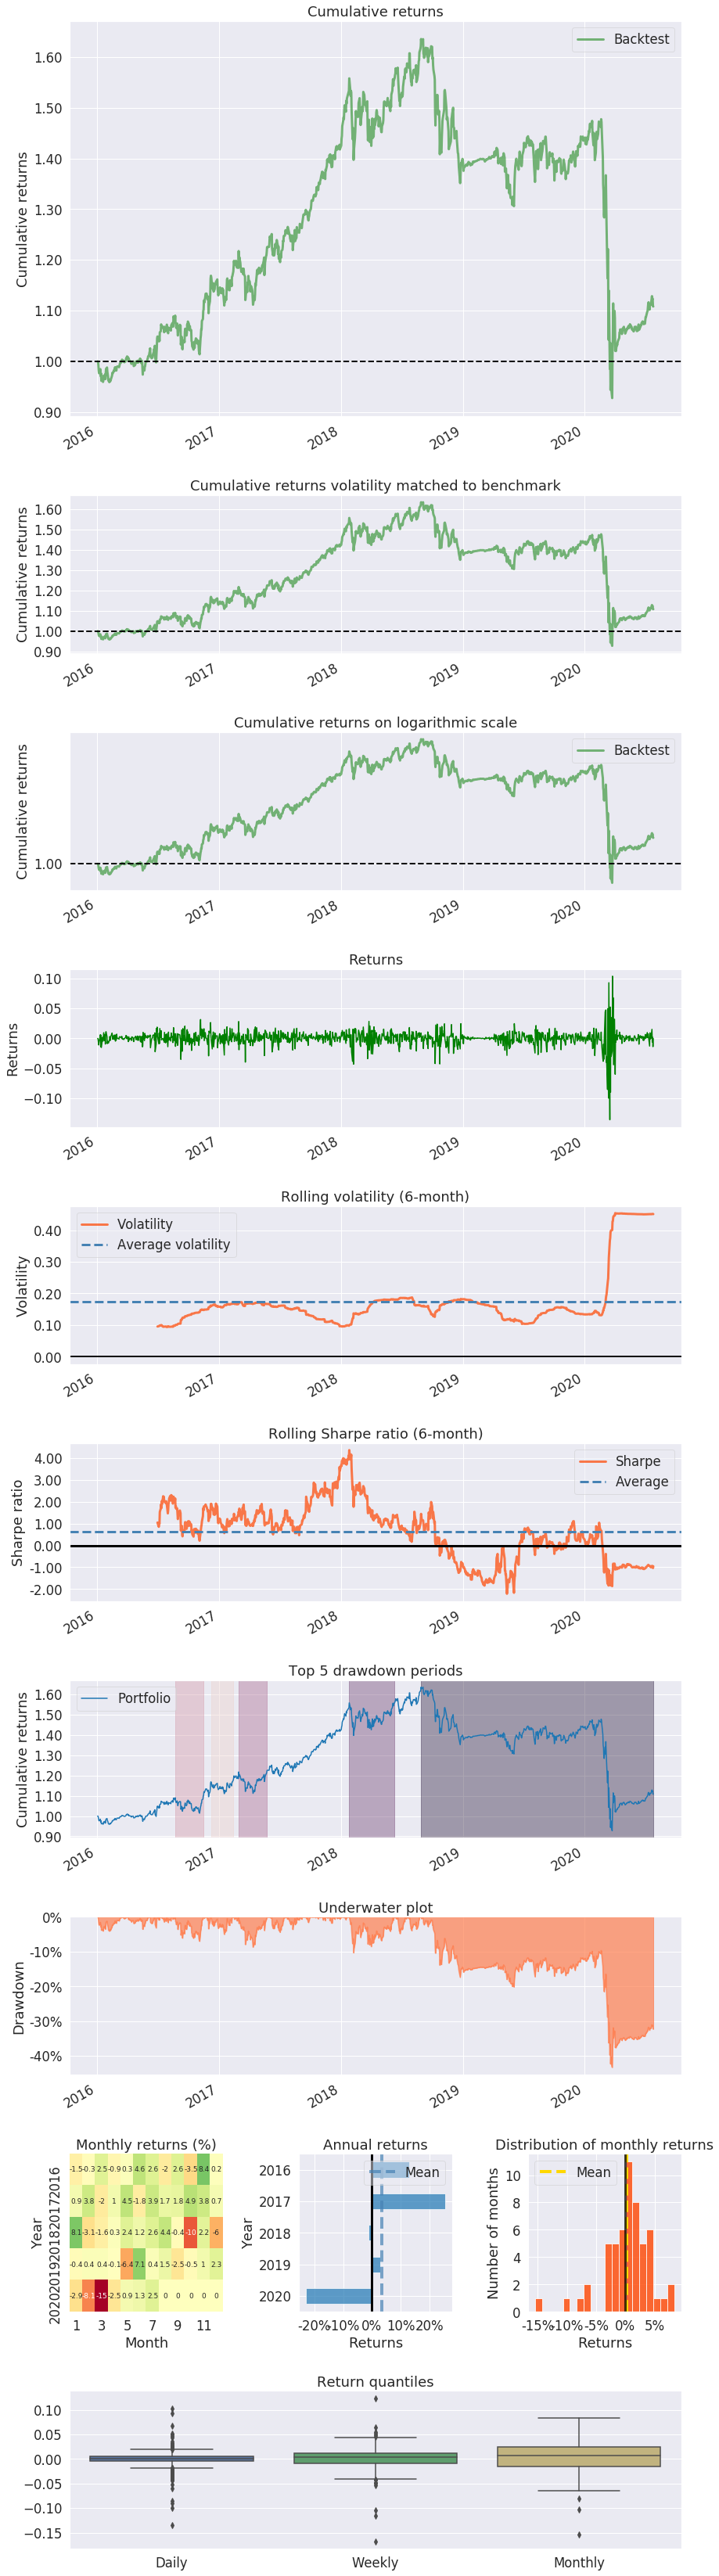

In [5]:
# Annualized Return: 11.50% Max Drawdown: -42.30%
# Annualized Return: 11.07% Max Drawdown: -39.83%

# 90 - Annualized Return: 9.00% Max Drawdown: -38.83%
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

In [29]:
perf.portfolio_value.to_csv('125d version.csv')